In [4]:
import pandas as pd
import seaborn as sns

posts = pd.read_csv("reddit_wsb.csv")
posts.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [7]:
df = pd.read_csv("nasdaq_screener_1647879349140.csv")
names = [df["Name"].str.split()]
cleaned = []

for name in names:
    list_remove = ["Corporation", "Common", "Stock", "Inc.", "Inc", "A", "Corp.", "Ltd.", "Systems", "Shares", "Holdings", "Class", "Limited", "Co.", "INC.", "Holding", "I", "Unit", "Warrant"]
    for element in name:
        name_new = []
        for word in element:
            if word not in list_remove:
                name_new.append(word)
        cleaned.append(" ".join(name_new))

ticker_name = []
ticker_df = pd.DataFrame()
for name in cleaned:
    ticker_name.append(name)
ticker_df["Ticker"] = '$' + df["Symbol"]
ticker_df["Name"] = ticker_name
ticker_list = ticker_name
ticker_set = set()
for element in ticker_df['Ticker']:
    ticker_set.add(element)
for element in ticker_df['Name']:
    ticker_set.add(element)
ticker_set.add("NOK")
ticker_set.add("GME")
ticker_set.add("AMC")
ticker_set.add("AYX")

ticker_df.head()

,Ticker,Name
0,$AACG,ATA Creativity Global American Depositary
1,$AACI,Armada Acquisition
2,$AACIU,Armada Acquisition
3,$AACIW,Armada Acquisition
4,$AADI,Aadi Bioscience


In [8]:
posts_viral = posts[posts["score"] >= 50000].copy()
posts_viral["Viral"] = 1
posts_nonviral = posts[posts["score"] < 50000].copy()
posts_nonviral["Viral"] = 0
posts_labeled = pd.concat([posts_viral, posts_nonviral])

In [9]:
posts_labeled.head()

,title,score,id,url,comms_num,created,body,timestamp,Viral
118,HOORAY FOR CHARLES PAYNE! “The shorts have had...,52047,l6popa,https://i.redd.it/nhc2rhacl0e61.jpg,1514,1.611843e+09,NaN,2021-01-28 16:08:22,1
128,"An Open Letter to Melvin Capital, CNBC, Boomer...",65148,l6omry,https://www.reddit.com/r/wallstreetbets/commen...,4480,1.611839e+09,"**Mods do not delete, this is important to me...",2021-01-28 15:06:14,1
155,WSB'S REVENGE - CALLING ALL 🦍🦍🦍 TO KEEP YOUR 🍌...,77324,l6mwjk,https://v.redd.it/3s5ue35dtzd61,2469,1.611834e+09,NaN,2021-01-28 13:32:49,1
182,None of these individuals are part of Wallstre...,52137,l6k3pi,https://twitter.com/stoolpresidente/status/135...,6063,1.611825e+09,NaN,2021-01-28 11:16:15,1
194,Can we all take a moment and appreciate the Mo...,160999,l6jobf,https://www.reddit.com/r/wallstreetbets/commen...,6515,1.611824e+09,NaN,2021-01-28 10:57:32,1


In [10]:
from datetime import datetime, timedelta
from yahoofinancials import YahooFinancials
import re
import string

def pre_processing(df, threshold):
    posts_viral = df[df["score"] >= threshold].copy()
    posts_viral["Viral"] = 1
    posts_nonviral = df[df["score"] < threshold].copy()
    posts_nonviral["Viral"] = 0
    posts_labeled = pd.concat([posts_viral, posts_nonviral])
    posts_labeled = posts_labeled.fillna(value="")
    posts_labeled["Combined"] = posts_labeled["title"] + " " + posts_labeled["body"]
    return posts_labeled

def post_to_list(post):
    return post.split()

def post_to_set(post):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    post = regex.sub("", post)
    return set(post.split())
    
def bag_of_words(posts):
    dictionary = {}
    for post in posts:
        word_list = post_to_list(post)
        for word in word_list:
            if word not in dictionary:
                dictionary[word] = len(dictionary)
    return dictionary

def feature_vector(posts, dictionary):
    feature_matrix = np.zeroes([len(posts), len(dictionary)], dtype=np.float64)
    for i, post in enumerate(posts):
        word_list = post_to_list(post)
        for word in word_list:
            if word in dictionary:
                feature_matrix[i, dictionary[word]] += 1
    return feature_matrix

def get_prices_df(ticker, start, end):
    t = YahooFinancials(ticker)
    data = t.get_historical_price_data(start_date=start, end_date=end, time_interval="daily")
    df = pd.DataFrame()
    # if 'dividends' in data[ticker]['eventsData'].keys():
    df = pd.DataFrame(data[ticker]['prices'])
    df = df.drop('date', axis=1).set_index('formatted_date')
    df["Return"] = df["adjclose"]/df["adjclose"].shift(1) - 1
    
    return df

def get_returns(ticker, date, returns_df):
    start = date
    end = date + 1 # next day
    return returns_df[returns_df["Ticker"] == ticker & returns_df["Date"] == date]["Returns"]

def extract_tickers(posts):
    tickers_list = []
    for i, post in enumerate(posts["Combined"]):
        tickers = set(post_to_set(post)).intersection(ticker_set)
        tickers_list.append([element for element in tickers])
    posts["Ticker"] = tickers_list
    return posts

posts = pre_processing(posts, 25000)
posts = extract_tickers(posts)

# Filter for posts including only one stock for training data
posts_stocks_mentioned = posts[[len(ticker_set) == 1 for ticker_set in posts["Ticker"]]].copy()

posts_stocks_mentioned["Ticker"] = posts_stocks_mentioned["Ticker"].str[0]

def format_ticker(ser):
    x = ser
    if not ser.str.isupper().iloc[0]:
        ticker = ser.iloc[0]
        x = ticker_df[ticker_df["Name"] == ticker]['Ticker'].values[0]
    return x
    
posts_stocks_mentioned['Ticker'] = posts_stocks_mentioned.groupby('Ticker')['Ticker'].transform(format_ticker)
posts_stocks_mentioned.head()

,title,score,id,url,comms_num,created,body,timestamp,Viral,Combined,Ticker
136,I’m so fucking proud of every single person in...,27451,l6ocfn,https://www.reddit.com/r/wallstreetbets/commen...,1471,1.611838e+09,This probably won’t get anywhere and I don’t c...,2021-01-28 14:50:34,1,I’m so fucking proud of every single person in...,GME
199,"Why AMC, Blackberry, Nok went down during afte...",32730,l6ji9t,https://www.reddit.com/r/wallstreetbets/commen...,3876,1.611824e+09,"Hedge fund managers, Short sellers, and Market...",2021-01-28 10:50:38,1,"Why AMC, Blackberry, Nok went down during afte...",AMC
15993,"I just bought $5,000 in $GME. I would not have...",73278,l78fuh,https://www.reddit.com/r/wallstreetbets/commen...,5293,1.611896e+09,I've been following /r/wallstreetbets for year...,2021-01-29 06:52:00,1,"I just bought $5,000 in $GME. I would not have...",GME
16009,GME YOLO update — Jan 28 2021,225870,l78uct,https://i.redd.it/opzucppb15e61.png,23309,1.611897e+09,,2021-01-29 07:06:23,1,GME YOLO update — Jan 28 2021,GME
16091,We cant let WSB get political no matter what,32053,l7ixaz,https://www.reddit.com/r/wallstreetbets/commen...,1881,1.611923e+09,I know everyone is excited about all the atten...,2021-01-29 14:16:46,1,We cant let WSB get political no matter what I...,GME


In [11]:
def filter_pop(x):
    return x['Ticker'].count() >= 10

top_50 = posts_stocks_mentioned.groupby('Ticker')['Ticker'].count().sort_values(ascending=False)[0:50]
keys = set(top_50.index)

# Filter by the stocks that have 10 or more posts
top = posts_stocks_mentioned.groupby('Ticker').filter(filter_pop)
keys = set(top['Ticker'])

In [12]:
stock_price_dict = {}

for ticker in keys:
    filt = posts_stocks_mentioned[posts_stocks_mentioned["Ticker"] == ticker]
    start = filt["timestamp"].min()
    start = datetime.fromisoformat(start) - timedelta(days=10)
    start = start.isoformat()[0:10]
    end = filt["timestamp"].max()
    end = datetime.fromisoformat(end) + timedelta(days=10)
    end = end.isoformat()[0:10]
    prices_df = get_prices_df(ticker.lstrip('$'), start, end)
    
    stock_price_dict[ticker] = prices_df

In [13]:
dates_list = top['timestamp'].values
t_list = top['Ticker'].values

returns = []

for i in range(len(dates_list)):
    ticker = t_list[i]
    prices = stock_price_dict[ticker]
    date = datetime.fromisoformat(dates_list[i]).date()
    while date.isoformat() not in prices.index and date.isoformat() <= prices.index.max():
        date = date + timedelta(days=1)
    returns.append(prices['Return'].loc[date.isoformat()])
    
top['returns'] = returns
ls = []
for ret in top['returns']:
    if ret >= 0:
        ls.append(1)
    else:
        ls.append(0)

top['Positive Predictive Value'] = ls

In [33]:
import numpy as np

with open("negative_words.txt") as f:
    raw_text_neg = f.readlines()

neg_set = set()
for line in raw_text_neg:
    neg_set.add(line.rstrip("\n"))
    
with open("positive_words.txt") as f:
    raw_text_pos = f.readlines()

pos_set = set()
for line in raw_text_pos:
    pos_set.add(line.rstrip("\n"))

r_specific_pos = {
    "moon",
    "highs",
    "mooning",
    "long",
    "call",
    "calls",
    "break", 
    "tendie",
    "tendies",
    "town", 
    "undervalued",
    "buy", 
    "bullish", 
    "stonk", 
    "green", 
    "money", 
    "print", 
    "rocket", 
    "bull", 
    "upgrade", 
    "hot", 
    "crack",
}

r_specific_neg = {
    "citron",
    "hidenburg",
    "short",
    "put",
    "puts",
    "overvalued",
    "sell",
    "gone",
    "gtfo",
    "paper",
    "bearish",
    "bagholder",
    "bear",
    "pumping",
    "sus",
    "offering",
    "rip",
    "downgrade",
    "drop",
    "dump"
}

pos_set = pos_set.union(r_specific_pos)
neg_set = neg_set.union(r_specific_neg)

@np.vectorize
def score_sentiment(dict):
    count = 0
    for key in dict.keys():
        neg = key in neg_set
        pos = key in pos_set
        if not (neg and pos):
            if neg:
                count -= dict.get(key)
            elif pos:
                count += dict.get(key)
    return count

def process(post):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    post = regex.sub("", post)
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, "", post)

def frequency_map(post):
    post = process(post)
    word_list = post.split(" ")
    freq = {}
    for word in word_list:
        val = freq.get(word)
        if val == None:
            freq[word] = 1
        else:
            freq[word] = val + 1
    return freq

top["word map"] = [frequency_map(post) for post in top["Combined"]]
top["Sentiment"] = score_sentiment(top['word map'])
top["Sentiment"] = top["Sentiment"] + np.abs(top["Sentiment"].min())
top.head()

,title,score,id,url,comms_num,created,body,timestamp,Viral,Combined,Ticker,returns,Positive Predictive Value,word map,Sentiment
136,I’m so fucking proud of every single person in...,27451,l6ocfn,https://www.reddit.com/r/wallstreetbets/commen...,1471,1.611838e+09,This probably won’t get anywhere and I don’t c...,2021-01-28 14:50:34,1,I’m so fucking proud of every single person in...,GME,-0.442894,0,"{'I’m': 2, 'so': 1, 'fucking': 4, 'proud': 3, ...",83
199,"Why AMC, Blackberry, Nok went down during afte...",32730,l6ji9t,https://www.reddit.com/r/wallstreetbets/commen...,3876,1.611824e+09,"Hedge fund managers, Short sellers, and Market...",2021-01-28 10:50:38,1,"Why AMC, Blackberry, Nok went down during afte...",AMC,-0.566332,0,"{'Why': 1, 'AMC': 1, 'Blackberry': 1, 'Nok': 1...",84
15993,"I just bought $5,000 in $GME. I would not have...",73278,l78fuh,https://www.reddit.com/r/wallstreetbets/commen...,5293,1.611896e+09,I've been following /r/wallstreetbets for year...,2021-01-29 06:52:00,1,"I just bought $5,000 in $GME. I would not have...",GME,0.678719,1,"{'I': 10, 'just': 2, 'bought': 2, '5000': 1, '...",80
16009,GME YOLO update — Jan 28 2021,225870,l78uct,https://i.redd.it/opzucppb15e61.png,23309,1.611897e+09,,2021-01-29 07:06:23,1,GME YOLO update — Jan 28 2021,GME,0.678719,1,"{'GME': 1, 'YOLO': 1, 'update': 1, '—': 1, 'Ja...",86
16091,We cant let WSB get political no matter what,32053,l7ixaz,https://www.reddit.com/r/wallstreetbets/commen...,1881,1.611923e+09,I know everyone is excited about all the atten...,2021-01-29 14:16:46,1,We cant let WSB get political no matter what I...,GME,0.678719,1,"{'We': 2, 'cant': 1, 'let': 2, 'WSB': 2, 'get'...",78


In [87]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

def get_metrics(model, test_data, y_test, y_pred, Flag=True):
    print(accuracy_score(y_test, y_pred), ": is the accuracy score")
    print(precision_score(y_test, y_pred), ": is the precision score")
    print(recall_score(y_test, y_pred), ": is the recall score")
    print(f1_score(y_test, y_pred), ": is the f1 score")
    if(Flag):
        plot_confusion_matrix(model, test_data, y_test)

### MultinomialNB Naive Bayes Classifier for Predicting Whether Post Content Has A Buy or Sell Sentiment

0.619157848324515 : is the accuracy score
0.6274930960417306 : is the precision score
0.799296462771155 : is the recall score
0.7030511388053288 : is the f1 score


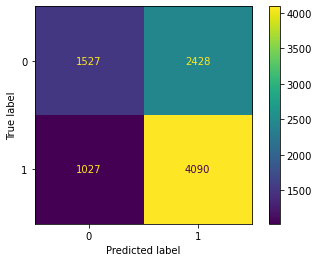

In [26]:
NB_model = make_pipeline(CountVectorizer(binary=True, stop_words='english', min_df=50), MultinomialNB())
data = top['Combined']

train_data, test_data, train_target, test_target = train_test_split(
    data, top['Positive Predictive Value'], test_size=0.7, random_state=216)

NB_model.fit(train_data, train_target)
predicted = NB_model.predict(test_data)
get_metrics(NB_model, test_data, test_target, predicted)

### Hyperparameter Tuning with GridSearchCV for MultinomialNB model

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.8s finished


0.6124338624338624 : is the accuracy score
0.6261225775957145 : is the precision score
0.7766269298417041 : is the recall score
0.6933007676203768 : is the f1 score


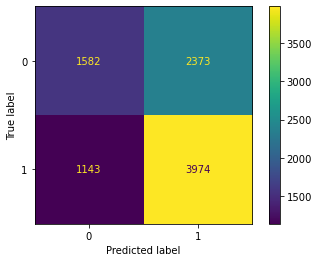

In [27]:
param_grid_nb = {
    'alpha': np.logspace(0,-9, num=100)
}

text_counter=CountVectorizer(binary=True, stop_words='english', min_df=50)
vectorized_data = text_counter.fit_transform(top['Combined'].values)
train_data, test_data, train_target, test_target = train_test_split(
    vectorized_data, top['Positive Predictive Value'], test_size=0.7, random_state=216)

nbModel_grid = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(train_data, train_target)
y_pred = nbModel_grid.predict(test_data)

get_metrics(nbModel_grid, test_data, test_target, y_pred)

### Naive Bayes Model with Post Score and Number of Comments as Additional Features
Adding more information actually worsened the model, possibly due to overfitting.

0.5859788359788359 : is the accuracy score
0.5892224990166514 : is the precision score
0.8782489740082079 : is the recall score
0.7052730696798494 : is the f1 score


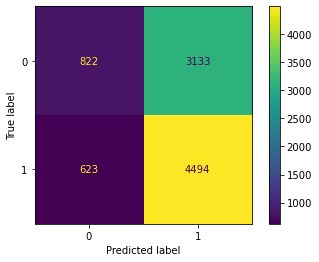

In [28]:
param_grid_nb = {
    'alpha': np.logspace(0,-9, num=100)
}

text_counter = CountVectorizer(binary=True, stop_words='english', min_df=50)
vectorized_data = text_counter.fit_transform(top['Combined'].values)
data = np.append(vectorized_data.toarray(), top[['comms_num', 'score']].values, axis=1)
train_data, test_data, train_target, test_target = train_test_split(
    data, top['Positive Predictive Value'], test_size=0.7, random_state=216)

nbModelInfo_grid = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid_nb, verbose=0, cv=10, n_jobs=-1)
nbModelInfo_grid.fit(train_data, train_target)
y_pred = nbModelInfo_grid.predict(test_data)

get_metrics(nbModelInfo_grid, test_data, test_target, y_pred)

### Naive Bayes with Sentiment as Additional Feature
Again, adding this feature did not help.

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   57.9s finished


0.5943562610229277 : is the accuracy score
0.6076404494382023 : is the precision score
0.7926519444987298 : is the recall score
0.6879240162822253 : is the f1 score


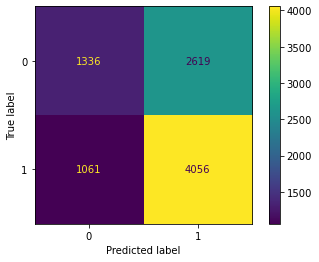

In [57]:
param_grid_nb = {
    'alpha': np.logspace(0,-9, num=100)
}

text_counter=CountVectorizer(binary=True, stop_words='english', min_df=50)
vectorized_data = text_counter.fit_transform(top['Combined'].values)
data = np.append(vectorized_data.toarray(), top[['Sentiment']].values, axis=1)
train_data, test_data, train_target, test_target = train_test_split(
    data, top['Positive Predictive Value'], test_size=0.7, random_state=216)

nbModel_grid = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(train_data, train_target)
y_test = test_target
y_pred = nbModel_grid.predict(test_data)

get_metrics(nbModel_grid, test_data, y_test, y_pred)

### Naive Bayes with Viral as Additional Input

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


0.6124338624338624 : is the accuracy score
0.6263614838200473 : is the precision score
0.7754543677936291 : is the recall score
0.6929793922458958 : is the f1 score


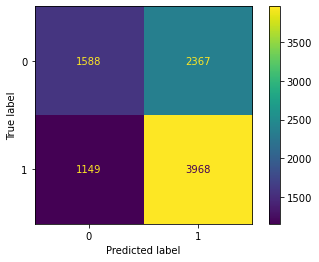

In [147]:
param_grid_nb = {
    'alpha': np.logspace(0,-9, num=100)
}

text_counter=CountVectorizer(binary=True, stop_words='english', min_df=50)
vectorized_data = text_counter.fit_transform(top['Combined'].values)
data = np.append(vectorized_data.toarray(), top[['Viral']].values, axis=1)
train_data, test_data, train_target, test_target = train_test_split(
    data, top['Positive Predictive Value'], test_size=0.7, random_state=216)

nbModel_grid = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(train_data, train_target)
y_test = test_target
y_pred = nbModel_grid.predict(test_data)

get_metrics(nbModel_grid, test_data, y_test, y_pred)

0.6048280423280423 : is the accuracy score
0.6290866194809572 : is the precision score
0.7295290209106898 : is the recall score
0.6755949687811058 : is the f1 score


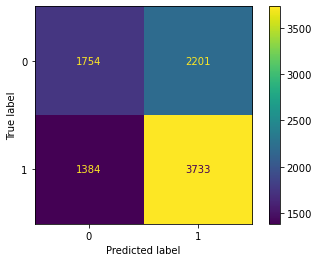

In [54]:
from sklearn.linear_model import LogisticRegression
logistic_model = make_pipeline(CountVectorizer(binary=True, stop_words='english', min_df=50), LogisticRegression())
data = top['Combined']

train_data, test_data, train_target, test_target = train_test_split(
    data, top['Positive Predictive Value'], test_size=0.7, random_state=216)

logistic_model.fit(train_data, train_target)
y_pred = logistic_model.predict(test_data)

get_metrics(logistic_model, test_data, test_target, y_pred)

### K Nearest Neighbors Classifier for Whether Stock Will go Up or Down

0.5844356261022927 : is the accuracy score
0.5895016611295681 : is the precision score
0.8669142075434825 : is the recall score
0.7017876918209144 : is the f1 score


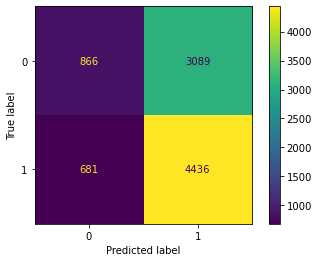

In [55]:
text_counter=CountVectorizer(binary=True, stop_words='english', min_df=50)
vectorized_data = text_counter.fit_transform(top['Combined'].values)
train_data, test_data, train_target, test_target = train_test_split(
    vectorized_data, top['Positive Predictive Value'], test_size=0.7, random_state=216)

KN_model = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': range(1, 30)})
KN_model.fit(train_data, train_target)
y_pred = KN_model.predict(test_data)
get_metrics(KN_model, test_data, test_target, y_pred)

### Predicting Whether a Post Containing a Stock Will go Viral

0.8851410934744268 : is the accuracy score
0.10770577933450087 : is the precision score
0.8424657534246576 : is the recall score
0.19099378881987578 : is the f1 score


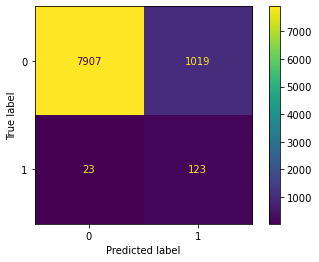

In [58]:
NB_model_viral = MultinomialNB()
text_counter=CountVectorizer(binary=True, stop_words='english', min_df=50)
vectorized_data = text_counter.fit_transform(top['Combined'].values)
data = np.append(vectorized_data.toarray(), top[['comms_num', 'score']].values, axis=1)

train_data, test_data, train_target, test_target = train_test_split(
    data, top['Viral'], test_size=0.7, random_state=216)

NB_model_viral.fit(train_data, train_target)
y_pred = NB_model_viral.predict(test_data)

get_metrics(NB_model_viral, test_data, test_target, y_pred)

### K Nearest Neighbor Classifier Taking only Post Content and Sentiment as Input

In [ ]:
text_counter=CountVectorizer(binary=True, stop_words='english', min_df=50)
vectorized_data = text_counter.fit_transform(top['Combined'].values)
data = np.append(vectorized_data.toarray(), OneHotEncoder().fit_transform(top['Predicted Sentiment'].values.reshape(-1, 1)).toarray(), axis=1)
train_data, test_data, train_target, test_target = train_test_split(
    data, top['Viral'], test_size=0.7, random_state=216)

KN_model = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': range(1, 30)})
KN_model.fit(train_data, train_target)
y_pred = KN_model.predict(test_data)
get_metrics(KN_model, test_data, test_target, y_pred)

### K Nearest Neighbor Classifier to Determine Whether Post will go Viral with Sentiment as Added Input

0.9987874779541446 : is the accuracy score
0.9927007299270073 : is the precision score
0.9315068493150684 : is the recall score
0.96113074204947 : is the f1 score


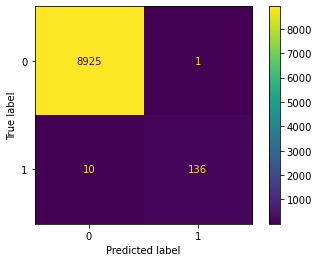

In [146]:
text_counter=CountVectorizer(binary=True, stop_words='english', min_df=50)
vectorized_data = text_counter.fit_transform(top['Combined'].values)
data = np.append(vectorized_data.toarray(), top[['comms_num', 'score']].values, axis=1)
data = np.append(data, OneHotEncoder().fit_transform(top['Predicted Sentiment'].values.reshape(-1, 1)).toarray(), axis=1)
train_data, test_data, train_target, test_target = train_test_split(
    data, top['Viral'], test_size=0.7, random_state=216)

KN_model = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': range(1, 30)})
KN_model.fit(train_data, train_target)
y_pred = KN_model.predict(test_data)
get_metrics(KN_model, test_data, test_target, y_pred)

### Hyperparameter Tuning for Naive Bayes Classifier for Determining Whether a Post will Go Viral

In [ ]:
param_grid_nb = {
    'alpha': np.logspace(0,-9, num=100)
}

text_counter=CountVectorizer(binary=True, stop_words='english', min_df=50)
vectorized_data = text_counter.fit_transform(top['Combined'].values)
data = np.append(vectorized_data.toarray(), top[['comms_num', 'score']].values, axis=1)

train_data, test_data, train_target, test_target = train_test_split(
    data, top['Viral'], test_size=0.7, random_state=216)

nbModel_grid = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(train_data, train_target)
y_pred = nbModel_grid.predict(test_data)

get_metrics(nbModel_grid)

### Using TfidVectorizer

In [67]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
vectorized_data = vectorizer.fit_transform(top['Combined'].values)

[nltk_data] Downloading package stopwords to /Users/mtome/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   33.8s finished


0.9012345679012346 : is the accuracy score
0.12349397590361445 : is the precision score
0.8424657534246576 : is the recall score
0.21541155866900175 : is the f1 score


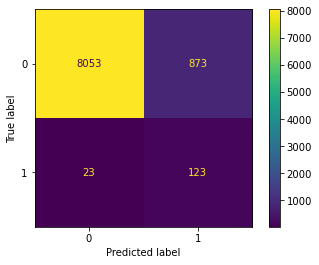

In [69]:
data = np.append(vectorized_data.toarray(), top[['comms_num', 'score']].values, axis=1)

train_data, test_data, train_target, test_target = train_test_split(
    data, top['Viral'], test_size=0.7, random_state=216)

nbModel_grid = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(train_data, train_target)
y_pred = nbModel_grid.predict(test_data)

get_metrics(nbModel_grid, test_data, test_target, y_pred)

0.611331569664903 : is the accuracy score
0.6163862472567666 : is the precision score
0.8233339847566934 : is the recall score
0.7049866131191432 : is the f1 score


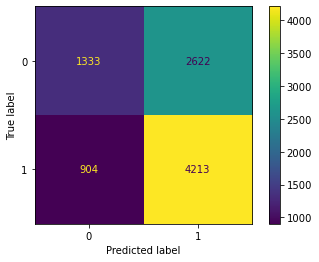

In [70]:
NB_model = make_pipeline(TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english')), MultinomialNB())
data = top['Combined']

train_data, test_data, train_target, test_target = train_test_split(
    data, top['Positive Predictive Value'], test_size=0.7, random_state=216)

NB_model.fit(train_data, train_target)
predicted = NB_model.predict(test_data)
get_metrics(NB_model, test_data, test_target, predicted)

### Predicting Sentiment

In [122]:
# Normalize the sentiment to make it on a scale of (0, 1)
sentiment_analysis = top.copy()
sentiment_analysis['Sentiment'] = sentiment_analysis['Sentiment'] / sentiment_analysis['Sentiment'].max()

vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
vectorized_data = vectorizer.fit_transform(sentiment_analysis['Combined'].values)

In [123]:
from sklearn.metrics import classification_report

def get_mets(y_test, y_pred):
    print(accuracy_score(y_test, y_pred), ": is the accuracy score")
    print(classification_report(y_test, y_pred))

In [124]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

ls_target = []
for val in sentiment_analysis['Sentiment']:
    if val >= .6:
        ls_target.append('pos')
    if .40 <= val < .60:
        ls_target.append('neu')
    if val < .40:
        ls_target.append('neg')
sentiment_analysis['Classified'] = ls_target

train_data, test_data, train_target, test_target = train_test_split(
    vectorized_data, ls_target, test_size=0.7, random_state=216)

SGDclassifier = SGDClassifier(max_iter=1000)
SGDclassifier.fit(train_data, train_target)
y_pred = SGDclassifier.predict(test_data)
get_mets(test_target, y_pred)

logistic_model = LogisticRegression()
logistic_model.fit(train_data, train_target)
y_pred = logistic_model.predict(test_data)
get_mets(test_target, y_pred)

rfc = RandomForestClassifier()
rfc.fit(train_data, train_target)
y_pred = rfc.predict(test_data)
get_mets(test_target, y_pred)

svc = SVC()
svc.fit(train_data, train_target)
y_pred = svc.predict(test_data)
get_mets(test_target, y_pred)

0.9786155202821869 : is the accuracy score
              precision    recall  f1-score   support

         neg       0.86      0.09      0.17        64
         neu       0.98      1.00      0.99      8872
         pos       0.50      0.07      0.12       136

    accuracy                           0.98      9072
   macro avg       0.78      0.39      0.43      9072
weighted avg       0.97      0.98      0.97      9072

0.9779541446208113 : is the accuracy score
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00        64
         neu       0.98      1.00      0.99      8872
         pos       0.00      0.00      0.00       136

    accuracy                           0.98      9072
   macro avg       0.33      0.33      0.33      9072
weighted avg       0.96      0.98      0.97      9072



/Users/mtome/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9781746031746031 : is the accuracy score
              precision    recall  f1-score   support

         neg       0.75      0.05      0.09        64
         neu       0.98      1.00      0.99      8872
         pos       0.00      0.00      0.00       136

    accuracy                           0.98      9072
   macro avg       0.58      0.35      0.36      9072
weighted avg       0.96      0.98      0.97      9072



/Users/mtome/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9781746031746031 : is the accuracy score
              precision    recall  f1-score   support

         neg       1.00      0.03      0.06        64
         neu       0.98      1.00      0.99      8872
         pos       0.00      0.00      0.00       136

    accuracy                           0.98      9072
   macro avg       0.66      0.34      0.35      9072
weighted avg       0.96      0.98      0.97      9072



### Using An Already Labeled Financial Sentiment Data Set to Perform Sentiment Analysis with Transfer Learning

In [117]:
financial_sentiments = pd.read_csv('data.csv')
financial_sentiments.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [187]:
vectorizer_log_model = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
vectorized_data = vectorizer_log_model.fit_transform(financial_sentiments['Sentence'].values)

train_data, test_data, train_target, test_target = train_test_split(
    vectorized_data, financial_sentiments['Sentiment'].values, test_size=0.7, random_state=216)

In [131]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

SGDclassifier = SGDClassifier(max_iter=1000)
SGDclassifier.fit(train_data, train_target)
y_pred = SGDclassifier.predict(test_data)
get_mets(test_target, y_pred)

logistic_model_t = LogisticRegression()
logistic_model_t.fit(train_data, train_target)
y_pred = logistic_model_t.predict(test_data)
get_mets(test_target, y_pred)

rfc = RandomForestClassifier()
rfc.fit(train_data, train_target)
y_pred = rfc.predict(test_data)
get_mets(test_target, y_pred)

svc = SVC()
svc.fit(train_data, train_target)
y_pred = svc.predict(test_data)
get_mets(test_target, y_pred)

0.617359413202934 : is the accuracy score
              precision    recall  f1-score   support

    negative       0.30      0.27      0.28       599
     neutral       0.69      0.72      0.71      2179
    positive       0.62      0.61      0.61      1312

    accuracy                           0.62      4090
   macro avg       0.54      0.53      0.53      4090
weighted avg       0.61      0.62      0.61      4090

0.6528117359413202 : is the accuracy score
              precision    recall  f1-score   support

    negative       0.40      0.12      0.19       599
     neutral       0.65      0.89      0.76      2179
    positive       0.70      0.49      0.58      1312

    accuracy                           0.65      4090
   macro avg       0.58      0.50      0.51      4090
weighted avg       0.63      0.65      0.62      4090

0.6366748166259169 : is the accuracy score
              precision    recall  f1-score   support

    negative       0.26      0.13      0.17       599
 

### Using the Previous Model to Predict Sentiment of the Reddit Posts to See if this will improve analysis
There was a negligible effect on performance of the model, indicating that the point measure of sentiment is as good as the entire text of the post in informing predictions.

In [133]:
vectorizer = TfidfVectorizer(max_features=1810, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
vectorized_data = vectorizer.fit_transform(top['Combined'].values)

top['Predicted Sentiment'] = logistic_model_t.predict(vectorized_data)

,title,score,id,url,comms_num,created,body,timestamp,Viral,Combined,Ticker,returns,Positive Predictive Value,word map,Sentiment,Predicted Sentiment
136,I’m so fucking proud of every single person in...,27451,l6ocfn,https://www.reddit.com/r/wallstreetbets/commen...,1471,1.611838e+09,This probably won’t get anywhere and I don’t c...,2021-01-28 14:50:34,1,I’m so fucking proud of every single person in...,GME,-0.442894,0,"{'I’m': 2, 'so': 1, 'fucking': 4, 'proud': 3, ...",83,neutral
199,"Why AMC, Blackberry, Nok went down during afte...",32730,l6ji9t,https://www.reddit.com/r/wallstreetbets/commen...,3876,1.611824e+09,"Hedge fund managers, Short sellers, and Market...",2021-01-28 10:50:38,1,"Why AMC, Blackberry, Nok went down during afte...",AMC,-0.566332,0,"{'Why': 1, 'AMC': 1, 'Blackberry': 1, 'Nok': 1...",84,neutral
15993,"I just bought $5,000 in $GME. I would not have...",73278,l78fuh,https://www.reddit.com/r/wallstreetbets/commen...,5293,1.611896e+09,I've been following /r/wallstreetbets for year...,2021-01-29 06:52:00,1,"I just bought $5,000 in $GME. I would not have...",GME,0.678719,1,"{'I': 10, 'just': 2, 'bought': 2, '5000': 1, '...",80,neutral
16009,GME YOLO update — Jan 28 2021,225870,l78uct,https://i.redd.it/opzucppb15e61.png,23309,1.611897e+09,,2021-01-29 07:06:23,1,GME YOLO update — Jan 28 2021,GME,0.678719,1,"{'GME': 1, 'YOLO': 1, 'update': 1, '—': 1, 'Ja...",86,neutral
16091,We cant let WSB get political no matter what,32053,l7ixaz,https://www.reddit.com/r/wallstreetbets/commen...,1881,1.611923e+09,I know everyone is excited about all the atten...,2021-01-29 14:16:46,1,We cant let WSB get political no matter what I...,GME,0.678719,1,"{'We': 2, 'cant': 1, 'let': 2, 'WSB': 2, 'get'...",78,neutral


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   30.6s finished


0.6140873015873016 : is the accuracy score
0.624768375540457 : is the precision score
0.7906976744186046 : is the recall score
0.6980074182696455 : is the f1 score


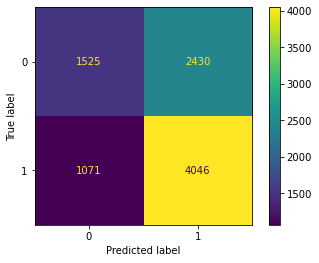

In [142]:
from sklearn.preprocessing import OneHotEncoder

param_grid_nb = {
    'alpha': np.logspace(0,-9, num=100)
}

text_counter=CountVectorizer(binary=True, stop_words='english', min_df=50)
vectorized_data = text_counter.fit_transform(top['Combined'].values)
data = np.append(vectorized_data.toarray(), OneHotEncoder().fit_transform(top['Predicted Sentiment'].values.reshape(-1, 1)).toarray(), axis=1)
train_data, test_data, train_target, test_target = train_test_split(
    data, top['Positive Predictive Value'], test_size=0.7, random_state=216)

nbModel_grid = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(train_data, train_target)
y_test = test_target
y_pred = nbModel_grid.predict(test_data)

get_metrics(nbModel_grid, test_data, y_test, y_pred)

### Using Sentiment as Added Input
#### K Nearest Neighbor Classifier for Determining Whether a Post Will go Viral with Predicted Sentiment as Added Input

0.9987874779541446 : is the accuracy score
0.9927007299270073 : is the precision score
0.9315068493150684 : is the recall score
0.96113074204947 : is the f1 score


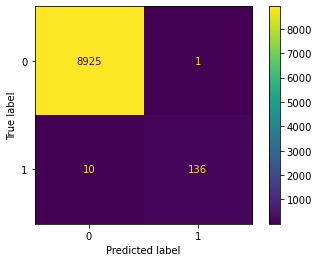

In [157]:
text_counter=CountVectorizer(binary=True, stop_words='english', min_df=50, max_features=1810)
vectorized_data = text_counter.fit_transform(top['Combined'].values)
data = np.append(vectorized_data.toarray(), top[['comms_num', 'score']].values, axis=1)
data = np.append(data, OneHotEncoder().fit_transform(top['Predicted Sentiment'].values.reshape(-1, 1)).toarray(), axis=1)
train_data, test_data, train_target, test_target = train_test_split(
    data, top['Viral'], test_size=0.7, random_state=216)

KN_model = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': range(1, 30)})
KN_model.fit(train_data, train_target)
y_pred = KN_model.predict(test_data)
get_metrics(KN_model, test_data, test_target, y_pred)

0.9847883597883598 : is the accuracy score
0.6818181818181818 : is the precision score
0.10273972602739725 : is the recall score
0.17857142857142855 : is the f1 score


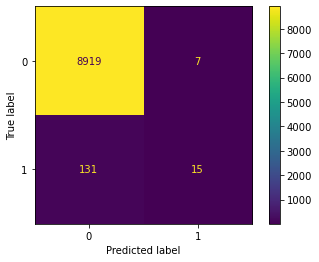

In [215]:
text_counter=CountVectorizer(binary=True, stop_words='english', min_df=50, max_features=1810)
vectorized_data = text_counter.fit_transform(top['Combined'].values)
data = np.append(vectorized_data.toarray(), OneHotEncoder().fit_transform(top['Predicted Sentiment'].values.reshape(-1, 1)).toarray(), axis=1)
train_data, test_data, train_target, test_target = train_test_split(
    data, top['Viral'], test_size=0.7, random_state=216)

KN_model = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': range(1, 30)})
KN_model.fit(train_data, train_target)
y_pred = KN_model.predict(test_data)
get_metrics(KN_model, test_data, test_target, y_pred)

### Using Predicted Sentiment to Inform Viral Predictions on Larger Dataset
Here we will see what viral posts the algorithm picks up in the larger dataset and see what stocks we can extract from these posts. We will check if our model generalizes well.
* We are going to use a scraper to pull posts from reddit made today and then see what viral posts our algorithm picks out. We will monitor the stocks selected over a period of one week.
* We will also monitor the submissions our algorithm marks as likely to go viral

In [201]:
import os
import praw
# Scrape with praw
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")
user_agent = os.getenv("USER_AGENT")
wsb = praw.Reddit(
    client_id='vtfLOCSH5cCE-9uRQ02Caw', client_secret='Q8yZ6yT69KFyBmsnqknNAsif1yf4Dw', user_agent='WSB Scraping'
).subreddit("wallstreetbets")

def download_data(ranked_by="hot", **kwargs):
    submissions = []
    if ranked_by == "hot":
        response = wsb.hot(**kwargs)
    elif ranked_by == "top":
        response = wsb.top(**kwargs)
    elif ranked_by == "new":
        response = wsb.new(**kwargs)

    for submission in response:
        post = []
        post = [
            submission.title,
            submission.selftext,
            submission.created_utc,
            submission.score,
            submission.num_comments
        ]
        submissions.append(post)
    df = pd.DataFrame(
        submissions,
        columns=[
            "title",
            "content",
            "created_on",
            "score",
            "comms_num"
        ],
    )
    df["created_on"] = pd.to_datetime(df["created_on"], dayfirst=True, unit="s")
    return df

In [218]:
p_new = download_data("top")
p_new['Combined'] = p_new['title'] + p_new['content']

vectorized_data = vectorizer_log_model.transform(p_new['Combined'].values)

p_new['Predicted Sentiment'] = logistic_model_t.predict(vectorized_data)

vectorized_data = text_counter.transform(p_new['Combined'].values)

#data = np.append(vectorized_data.toarray(), p_new[['comms_num', 'score']].values, axis=1)
data = np.append(vectorized_data.toarray(), OneHotEncoder().fit_transform(p_new['Predicted Sentiment'].values.reshape(-1, 1)).toarray(), axis=1)

p_new['Predicted Viral'] = KN_model.predict(data)

In [219]:
extract_tickers(p_new)

,title,content,created_on,score,comms_num,Combined,Predicted Sentiment,Predicted Viral,Ticker
0,Times Square right now,,2021-01-30 18:00:38,457356,13561,Times Square right now,neutral,0,[]
1,UPVOTE so everyone sees we got SUPPORT,,2021-01-28 13:40:34,327864,12958,UPVOTE so everyone sees we got SUPPORT,neutral,0,[]
2,GME YOLO update — Jan 28 2021,,2021-01-28 21:06:23,290278,23383,GME YOLO update — Jan 28 2021,neutral,0,[GME]
3,GME YOLO month-end update — Jan 2021,,2021-01-29 21:04:45,257884,20333,GME YOLO month-end update — Jan 2021,neutral,1,[GME]
4,It’s treason then,,2021-01-29 23:40:59,235642,4651,It’s treason then,neutral,0,[]
...,...,...,...,...,...,...,...,...,...
95,Some dickhead on CNN said the government shoul...,,2021-01-27 20:46:54,103693,3639,Some dickhead on CNN said the government shoul...,neutral,0,[]
96,GME Today...,,2021-03-10 20:42:16,103686,1668,GME Today...,neutral,0,[GME]
97,🔮WallStreetBets Predictions Tournament for Feb...,,2022-02-27 04:41:53,103122,362,🔮WallStreetBets Predictions Tournament for Feb...,neutral,0,[]
98,DEEPFUCKINGVALUE just TWEETED! HOLD THE FUCKIN...,,2021-02-03 17:06:10,102616,5146,DEEPFUCKINGVALUE just TWEETED! HOLD THE FUCKIN...,neutral,0,[]


In [220]:
p_new[p_new['Predicted Viral'] == 1]

,title,content,created_on,score,comms_num,Combined,Predicted Sentiment,Predicted Viral,Ticker
3,GME YOLO month-end update — Jan 2021,,2021-01-29 21:04:45,257884,20333,GME YOLO month-end update — Jan 2021,neutral,1,[GME]
37,GME YOLO month-end update — Feb 2021,,2021-02-26 21:07:18,147538,7805,GME YOLO month-end update — Feb 2021,neutral,1,[GME]


In [221]:
promising = set()

for ls in p_new['Ticker'].values:
    for element in ls:
        promising.add(element)

print(promising)

{'GME', 'Nasdaq', 'Fox', 'Comcast', 'TD', 'AMC'}
